# This session will explore the geographical distribution of the earthquakes

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

#Importing the csv's into dataframes
df1 = pd.read_csv('data/query.csv')
df2 = pd.read_csv('data/query (1).csv')
df3 = pd.read_csv('data/query (2).csv')

#Merging the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

#data cleaning, removing entries below 2in the mag column (original dataset was >=1)
df = df[df['mag']>=2]
df = df.dropna(subset=['mag'])

In [2]:
#Inspecting the data, columns, and types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7230 entries, 0 to 36961
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             7230 non-null   object 
 1   latitude         7230 non-null   float64
 2   longitude        7230 non-null   float64
 3   depth            7230 non-null   float64
 4   mag              7230 non-null   float64
 5   magType          7230 non-null   object 
 6   nst              7228 non-null   float64
 7   gap              7228 non-null   float64
 8   dmin             7186 non-null   float64
 9   rms              7228 non-null   float64
 10  net              7230 non-null   object 
 11  id               7230 non-null   object 
 12  updated          7230 non-null   object 
 13  place            7230 non-null   object 
 14  type             7230 non-null   object 
 15  horizontalError  6607 non-null   float64
 16  depthError       7230 non-null   float64
 17  magError         7

In [3]:
# Defining the bins for the magnitude ranges (e.g., 2 to 3, 3 to 4, etc.)
bins = [2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = ['2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']

# Bin the data based on the 'mag' column
df['mag_range'] = pd.cut(df['mag'], bins=bins, labels=labels, right=False)

# Counting the number of events in each magnitude range
magnitude_counts = df['mag_range'].value_counts().sort_index()

# Getting the counts for each range to determine the visualization limits
print(magnitude_counts)

mag_range
2-3     6322
3-4      766
4-5      129
5-6       13
6-7        0
7-8        0
8-9        0
9-10       0
Name: count, dtype: int64


In [5]:
#Removing the empty ranges
magnitude_counts = magnitude_counts[magnitude_counts > 0].reset_index(drop=True)
print(magnitude_counts)
magnitude_counts.info()


0    6322
1     766
2     129
3      13
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4 entries, 0 to 3
Series name: count
Non-Null Count  Dtype
--------------  -----
4 non-null      int64
dtypes: int64(1)
memory usage: 164.0 bytes


## Number of earthquakes by magnitude

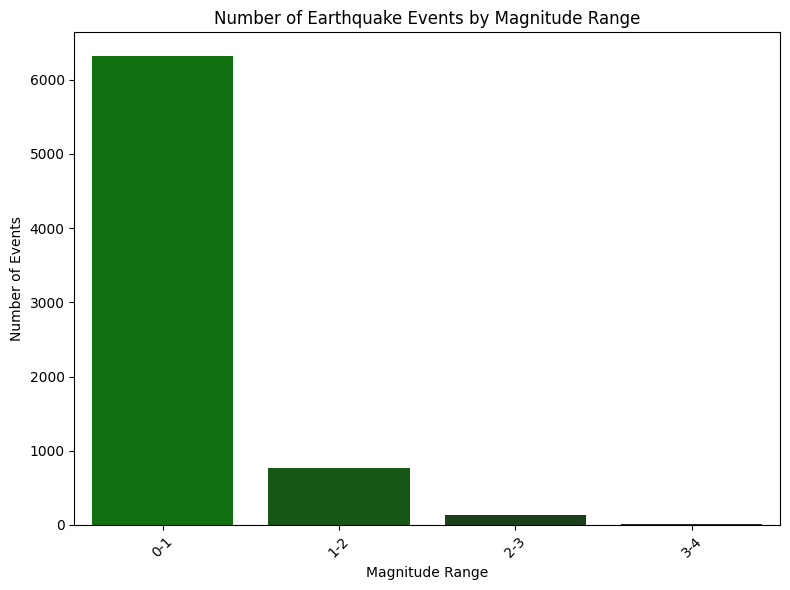

In [ ]:
# Visualization of the number of earthquakes by magnitude
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=magnitude_counts.index, y=magnitude_counts.values, palette='dark:g_r', hue=magnitude_counts.index)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x: f'{x+2}-{x+3}'))

# Use a lambda function to modify the x-axis labels
ax.set_xticks(magnitude_counts.index)
ax.set_xticklabels([f'{i}-{i+1}' for i in magnitude_counts.index], rotation=45)

# Customize the plot
ax.set_title('Number of Earthquake Events by Magnitude Range')
ax.set_xlabel('Magnitude Range')
ax.set_ylabel('Number of Events')

# Show the plot
plt.legend().remove()
plt.tight_layout()
plt.show()

The graph show that there is a correlatioin between the magnitude and the number of events. The higher the magnitude, the fewer the number of quake events.

## Geographical distribution of earthquakes

In [7]:
#This function will generate a plot with a US map on the background to show the location of the earthquakes
def geo_plot(data):

    # Convert the dataframe into a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, 
                        geometry=gpd.points_from_xy(data['longitude'], data['latitude']),
                        crs="EPSG:4326")

    # Load a world map (this will be used as a background)
    us_states = gpd.read_file('map/ne_110m_admin_1_states_provinces.shp')

    # Filter out Alaska and Hawaii (if using the "admin" column in shapefile, which contains state names)
    continental_us = us_states[~us_states['name'].isin(['Alaska', 'Hawaii'])]

    # Define the magnitude ranges (e.g., 2-3, 3-4, etc.)
    bins = [2, 3, 4, 5, 6]
    labels = ['2-3', '3-4', '4-5', '5-6']

    # Create a new column for magnitude ranges
    gdf['mag_range'] = pd.cut(gdf['mag'], bins=bins, labels=labels, right=False)

    # Define a color map for the magnitude ranges
    cmap = {
        '2-3': 'green',
        '3-4': 'yellow',
        '4-5': 'orange',
        '5-6': 'red',
    }

    # Map the magnitude ranges to colors
    gdf['color'] = gdf['mag_range'].map(cmap)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the U.S. states (excluding Alaska and Hawaii)
    continental_us.plot(ax=ax, color='lightgray')

    # Plot the earthquake locations, color-coded by magnitude range
    gdf.plot(ax=ax, color=gdf['color'], markersize=50)

    # Add a legend for the magnitude ranges
    from matplotlib.lines import Line2D

    # Define custom legend handles
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap[label], markersize=10) for label in labels]
    ax.legend(handles, labels, title="Magnitude Ranges", loc='lower right')

    # Customize the plot
    ax.set_title("Earthquake Locations by Magnitude")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Remove the tick labels and tick marks from the x and y axes
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

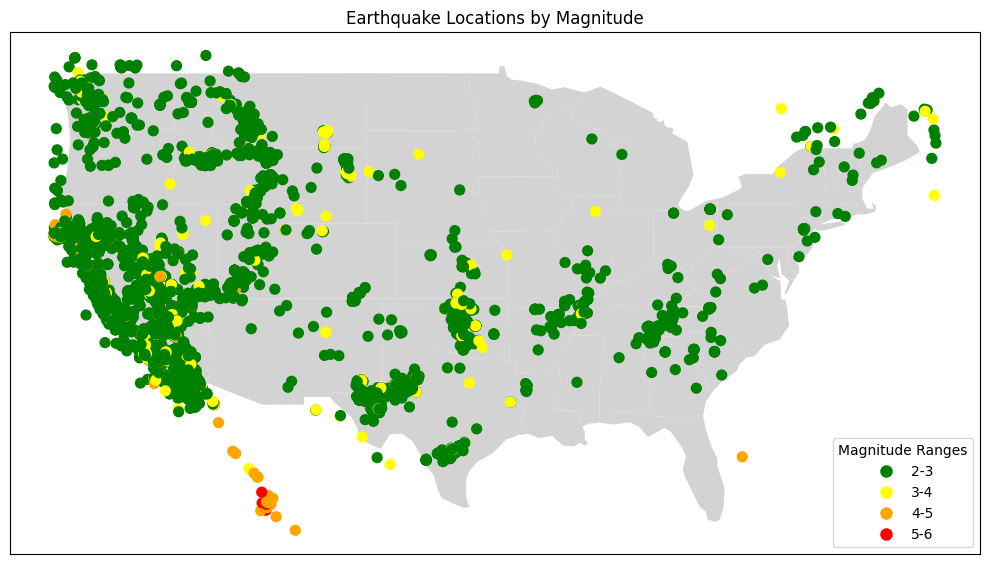

In [8]:
geo_plot(df)

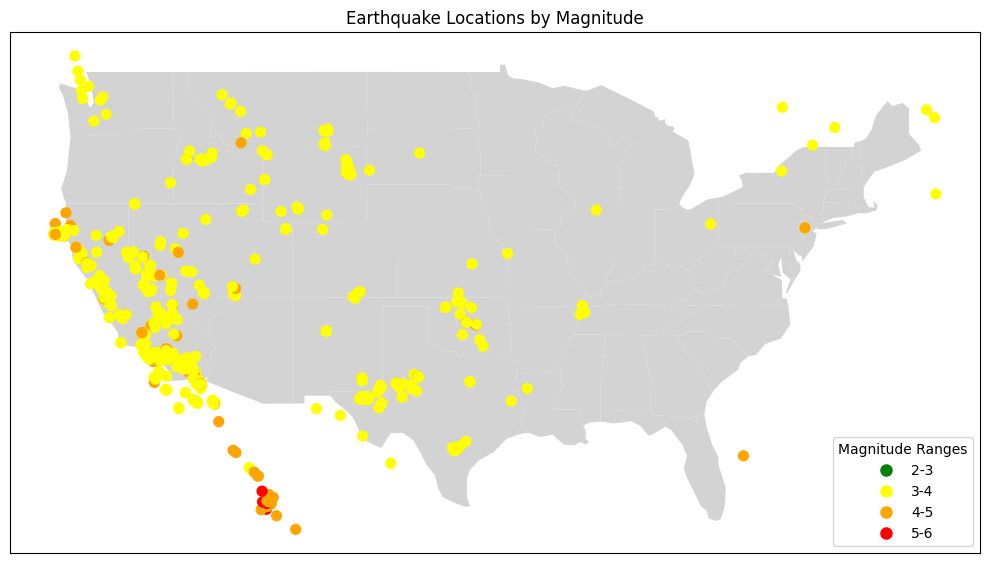

In [9]:
df_3 = df[df['mag']>=3]
geo_plot(df_3)

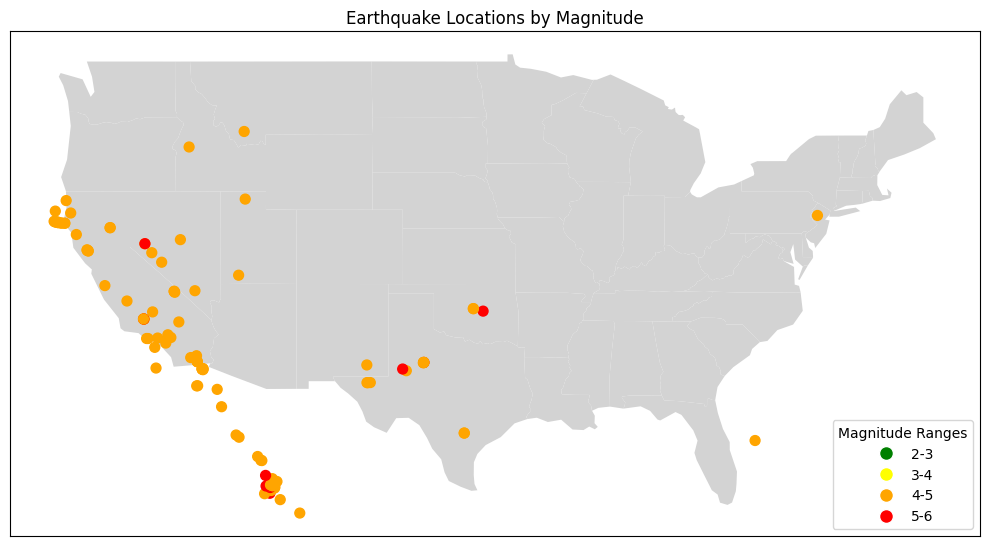

In [10]:
df_4 = df[df['mag']>=4]
geo_plot(df_4)

## Analysis of depth vs magnitude

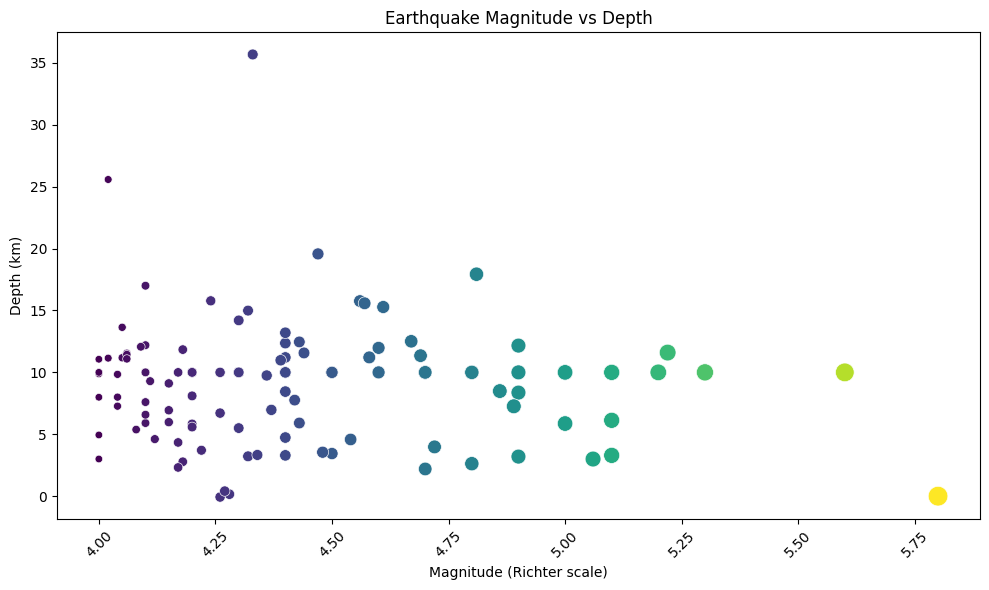

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_4, x='mag', y='depth', hue='mag', palette='viridis', size='mag', sizes=(30, 200), legend=None)

# Customize the plot
plt.title('Earthquake Magnitude vs Depth')
plt.xlabel('Magnitude (Richter scale)')
plt.ylabel('Depth (km)')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

## Time analysis

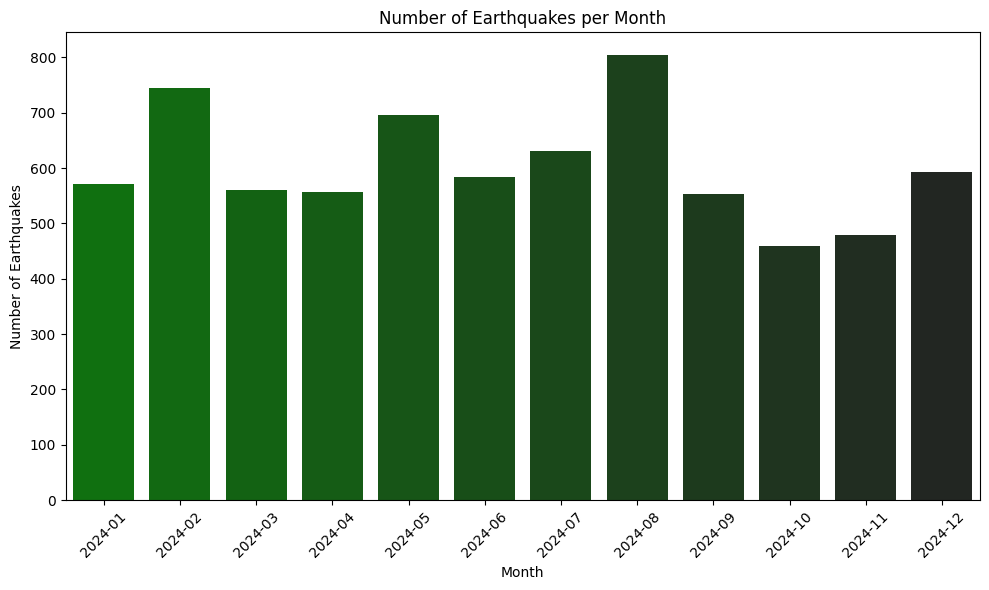

In [ ]:
# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Group by year and month, and count the number of earthquakes
df['year_month'] = df['time'].dt.tz_localize(None).dt.to_period('M')  # Create a 'Year-Month' period
earthquake_counts = df.groupby('year_month').size().reset_index(name='earthquake_count')

# Plot the number of earthquakes over time (by month)
plt.figure(figsize=(10, 6))
sns.barplot(x='year_month', y='earthquake_count', data=earthquake_counts, palette='dark:g_r', hue='year_month')

#earthquake_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Earthquakes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

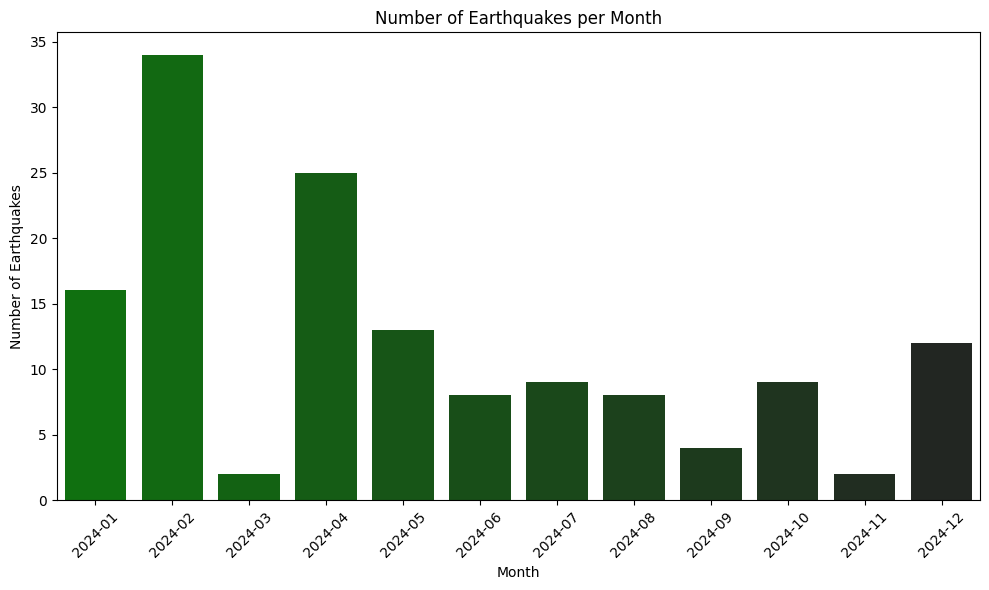

In [18]:
#Limiting the data to earthquakes of magnitude 4 and above
df_4t = df[df['mag']>=4]

# Group by year and month, and count the number of earthquakes
earthquake_counts_4t = df_4t.groupby('year_month').size().reset_index(name='earthquake_count')

# Plot the number of earthquakes over time (by month)
plt.figure(figsize=(10, 6))
sns.barplot(x='year_month', y='earthquake_count', data=earthquake_counts_4t, palette='dark:g_r', hue='year_month')

#earthquake_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Earthquakes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

No correlation between the number of earthquakes and the month of the year could be observed in this dataset. However it's worth noticing that a more accurate conclusion could be reached on a larger dataset spanning across several decades.